### Financial Terms and NLP bond

1. Financial Compliance

Financial compliance is the regulation and enforcement of the laws and rules in finance and the capital markets. It ranges through the entire financial spectrum, from investment banking practices to retail banking practices


## Text Summarization

Summarization
techniques 
Intitution: Keyphrase , grammatical structure ,  

Representation 
Extraction-based Summarization
Abstraction-based Summarization

Various Mmethods 


#unsupervised Extractive Summarization: A Comparative Study
Roadmap

Dataset: 
Techniques
Eval Metrics:ROUGE scores,
Issue
overcome 
https://towardsdatascience.com/understanding-automatic-text-summarization-1-extractive-methods-8eb512b21ecc



### Implementation
TFIDF and centroid embedding
https://towardsdatascience.com/a-better-approach-to-text-summarization-d7139b571439


Skipthought and Clustering
https://medium.com/jatana/unsupervised-text-summarization-using-sentence-embeddings-adb15ce83db1

In [2]:
import nltk
import re
import string
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize as nlkt_sent_tokenize
from nltk.tokenize import word_tokenize as nlkt_word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.corpus import stopwords
import numpy as np
from scipy.spatial.distance import cosine

#Calculates cosine similarity
def similarity(v1, v2):
    score = 0.0
    if np.count_nonzero(v1) != 0 and np.count_nonzero(v2) != 0:
        score = ((1 - cosine(v1, v2)) + 1) / 2
    return score

def sent_tokenize(text):
    sents = nlkt_sent_tokenize(text)
    sents_filtered = []
    for s in sents:
        sents_filtered.append(s)
    return sents_filtered

def cleanup_sentences(text):
    stop_words = set(stopwords.words('english'))
    sentences = sent_tokenize(text)
    sentences_cleaned = []
    for sent in sentences:
        words = nlkt_word_tokenize(sent)
        words = [w for w in words if w not in string.punctuation]
        words = [w for w in words if not w.lower() in stop_words]
        words = [w.lower() for w in words]
        sentences_cleaned.append(" ".join(words))
    return sentences_cleaned

def get_tf_idf(sentences):
    vectorizer = CountVectorizer()
    sent_word_matrix = vectorizer.fit_transform(sentences)

    transformer = TfidfTransformer(norm=None, sublinear_tf=False, smooth_idf=False)
    tfidf = transformer.fit_transform(sent_word_matrix)
    tfidf = tfidf.toarray()

    centroid_vector = tfidf.sum(0)
    centroid_vector = np.divide(centroid_vector, centroid_vector.max())

    feature_names = vectorizer.get_feature_names()

    relevant_vector_indices = np.where(centroid_vector > 0.3)[0]

    word_list = list(np.array(feature_names)[relevant_vector_indices])
    return word_list

#Populate word vector with all embeddings.
#This word vector is a look up table that is used
#for getting the centroid and sentences embedding representation.
def word_vectors_cache(sentences, embedding_model):
    word_vectors = dict()
    for sent in sentences:
        words = nlkt_word_tokenize(sent)
        for w in words:
            word_vectors.update({w: embedding_model.wv[w]})
    return word_vectors

# Sentence embedding representation with sum of word vectors
def build_embedding_representation(words, word_vectors, embedding_model):
    embedding_representation = np.zeros(embedding_model.vector_size, dtype="float32")
    word_vectors_keys = set(word_vectors.keys())
    count = 0
    for w in words:
        if w in word_vectors_keys:
            embedding_representation = embedding_representation + word_vectors[w]
            count += 1
    if count != 0:
       embedding_representation = np.divide(embedding_representation, count)
    return embedding_representation

def summarize(text, emdedding_model):
    raw_sentences = sent_tokenize(text)
    clean_sentences = cleanup_sentences(text)
    for i, s in enumerate(raw_sentences):
        print(i, s)
    for i, s in enumerate(clean_sentences):
        print(i, s)
    centroid_words = get_tf_idf(clean_sentences)
    print(len(centroid_words), centroid_words)
    word_vectors = word_vectors_cache(clean_sentences, emdedding_model)
    #Centroid embedding representation
    centroid_vector = build_embedding_representation(centroid_words, word_vectors, emdedding_model)
    sentences_scores = []
    for i in range(len(clean_sentences)):
        scores = []
        words = clean_sentences[i].split()

        #Sentence embedding representation
        sentence_vector = build_embedding_representation(words, word_vectors, emdedding_model)

        #Cosine similarity between sentence embedding and centroid embedding
        score = similarity(sentence_vector, centroid_vector)
        sentences_scores.append((i, raw_sentences[i], score, sentence_vector))
    sentence_scores_sort = sorted(sentences_scores, key=lambda el: el[2], reverse=True)
    for s in sentence_scores_sort:
        print(s[0], s[1], s[2])
    count = 0
    sentences_summary = []
    #Handle redundancy
    for s in sentence_scores_sort:
        if count > 100:
            break
        include_flag = True
        for ps in sentences_summary:
            sim = similarity(s[3], ps[3])
            if sim > 0.95:
                include_flag = False
        if include_flag:
            sentences_summary.append(s)
            count += len(s[1].split())

        sentences_summary = sorted(sentences_summary, key=lambda el: el[0], reverse=False)

    summary = "\n".join([s[1] for s in sentences_summary])
    print(summary)
    return summary

text = """In an attempt to build an AI-ready workforce, Microsoft announced Intelligent Cloud Hub
          which has been launched to empower the next generation of students with AI-ready skills.
         Envisioned as a three-year collaborative program, Intelligent Cloud Hub will support around 100
          institutions with AI infrastructure, course content and curriculum, developer support,
          development tools and give students access to cloud and AI services.
          As part of the program, the Redmond giant which wants to expand its reach and is
          planning to build a strong developer ecosystem in India with the program will set up the
          core AI infrastructure and IoT Hub for the selected campuses.
          The company will provide AI development tools and Azure AI services such as
          Microsoft Cognitive Services, Bot Services and Azure Machine Learning.
          According to Manish Prakash, Country General Manager-PS, Health and Education,
          Microsoft India, said, "With AI being the defining technology of our time,
          it is transforming lives and industry and the jobs of tomorrow will
          require a different skillset. This will require more collaborations and
          training and working with AI. That’s why it has become more critical than ever for
          educational institutions to integrate new cloud and AI technologies.
          The program is an attempt to ramp up the institutional set-up and build
          capabilities among the educators to educate the workforce of tomorrow."
          The program aims to build up the cognitive skills and in-depth understanding of
          developing intelligent cloud connected solutions for applications across industry.
          Earlier in April this year, the company announced Microsoft Professional
          Program In AI as a learning track open to the public.
          The program was developed to provide job ready skills to programmers who wanted to hone their
          skills in AI and data science with a series of online courses which featured hands-on labs and expert instructors as well.
          This program also included developer-focused AI school that provided a bunch of assets to help build AI skills."""

clean_sentences = cleanup_sentences(text)
words = []
for sent in clean_sentences:
    words.append(nlkt_word_tokenize(sent))
model = Word2Vec(words, min_count=1, sg = 1)
summarize(text, model)

C:\Users\HP\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\HP\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\HP\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\HP\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


0 In an attempt to build an AI-ready workforce, Microsoft announced Intelligent Cloud Hub
          which has been launched to empower the next generation of students with AI-ready skills.
1 Envisioned as a three-year collaborative program, Intelligent Cloud Hub will support around 100
          institutions with AI infrastructure, course content and curriculum, developer support,
          development tools and give students access to cloud and AI services.
2 As part of the program, the Redmond giant which wants to expand its reach and is
          planning to build a strong developer ecosystem in India with the program will set up the
          core AI infrastructure and IoT Hub for the selected campuses.
3 The company will provide AI development tools and Azure AI services such as
          Microsoft Cognitive Services, Bot Services and Azure Machine Learning.
4 According to Manish Prakash, Country General Manager-PS, Health and Education,
          Microsoft India, said, "With AI b

C:\Users\HP\AppData\Roaming\Python\Python38\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


'In an attempt to build an AI-ready workforce, Microsoft announced Intelligent Cloud Hub\n          which has been launched to empower the next generation of students with AI-ready skills.\nEnvisioned as a three-year collaborative program, Intelligent Cloud Hub will support around 100\n          institutions with AI infrastructure, course content and curriculum, developer support,\n          development tools and give students access to cloud and AI services.\nThe company will provide AI development tools and Azure AI services such as\n          Microsoft Cognitive Services, Bot Services and Azure Machine Learning.\nEarlier in April this year, the company announced Microsoft Professional\n          Program In AI as a learning track open to the public.'

In [11]:
# !pip install openpyxl
# !pip install pandas_datareader
!pip install nsetools
# !pip install moneycontrol
# !pip install yahoo_fin

import pandas as pd
# import streamlit as st
import matplotlib.pyplot as plt
import spacy
import re
import datetime as dt

import pandas_datareader.data as web
from yahoo_fin import stock_info as si


  Using cached nsetools-1.0.11-py3-none-any.whl (9.6 kB)
  Using cached dateutils-0.6.12-py2.py3-none-any.whl (5.7 kB)


You should consider upgrading via the 'c:\users\hp\anaconda3\python.exe -m pip install --upgrade pip' command.


(0, 6)


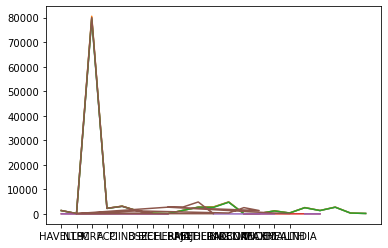

In [7]:
df=pd.read_csv('../stock_data/stock_data.csv',index_col=0)

plt.plot(df.iloc[:, 2:])
ax = plt.gca()
plt.plot(df['Symbol'],df['currentPrice'])

nlp = spacy.load("en_core_web_sm")
doc = nlp(u"Apple is looking at buying U.K. startup for $1 billion")

entities = [ent for ent in doc.ents if ent.label_ == "ORG"]

  
"""
We create a re.MatchObject and 
store it in  match_object variable, 
'()' parenthesis are used to define a 
specific group
"""
match_object = re.match(r'(\d+)',
                        '128935')
  
""" 
d in above pattern stands for numerical character
+ is used to match a consecutive set of characters 
satisfying a given condition so d+ will match a
consecutive set of numerical characters
"""
  
# generating the tuple with the 
# starting and ending index
print(match_object.span())

In [8]:
## 
# start_dt=dt.date(2021,3,1)
# end_dt=dt.date(2021,4,1)
# web.DataReader('tesla','yahoo',start_dt,end_dt)


##
si.get_live_price("aapl")

149.8000030517578

In [12]:

# importing nse from nse tools
from nsetools import Nse
 
# creating a Nse object
nse = Nse()


# getting quote of the sbin
quote = nse.get_quote('sbin')

nse.get_top_fno_gainers()
# # printing company name
# print(quote['companyName'])


[{'symbol': 'CANBK',
  'series': 'EQ',
  'openPrice': 194.65,
  'highPrice': 218.65,
  'lowPrice': 191.1,
  'ltp': 214.1,
  'previousPrice': 195.4,
  'netPrice': 9.57,
  'tradedQuantity': 72268109.0,
  'turnoverInLakhs': 151806.39,
  'lastCorpAnnouncementDate': '26-Jul-2021',
  'lastCorpAnnouncement': 'Annual General Meeting'},
 {'symbol': 'INDIGO',
  'series': 'EQ',
  'openPrice': 2000.0,
  'highPrice': 2189.7,
  'lowPrice': 1850.0,
  'ltp': 2168.0,
  'previousPrice': 1997.95,
  'netPrice': 8.51,
  'tradedQuantity': 5299099.0,
  'turnoverInLakhs': 110921.27,
  'lastCorpAnnouncementDate': '23-Aug-2021',
  'lastCorpAnnouncement': 'Annual General Meeting'},
 {'symbol': 'MCDOWELL-N',
  'series': 'EQ',
  'openPrice': 898.9,
  'highPrice': 963.4,
  'lowPrice': 881.5,
  'ltp': 951.05,
  'previousPrice': 892.55,
  'netPrice': 6.55,
  'tradedQuantity': 9686157.0,
  'turnoverInLakhs': 90764.13,
  'lastCorpAnnouncementDate': '13-Aug-2019',
  'lastCorpAnnouncement': 'Annual General Meeting'},
 {'